In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import interpolate, signal
import xarray as xr
%matplotlib inline

In [2]:
# some functions used here
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r  = np.sqrt( x**2 + y**2 )
    az = np.degrees( np.arctan2(x, y) )
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az

def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y

def buildGrid(xp,yp,alp,dx,dy,mxc,myc):
    '''
    X, Y = buildGrid(xp,yp,alp,dx,dy,mxc,myc) builds a rectangular grid
    
    Input :
        xp: x grid origin
        yp: y grid origin
        alp: degrees rotation of x-axis
        dx: x-direction grid spacing
        dy: y-direction grid spacing
        mxc: number of meshes in x-direction
        myc: number of meshes in y-direction
        
    Based on the Matlab function of Dave Thompson
    '''
    xlen = (mxc-1)*dx
    ylen = (myc-1)*dy
    
    x = np.arange(xp,xp+xlen+dx,dx)
    y = np.arange(yp,yp+ylen+dy,dy)

    X,Y = np.meshgrid(x,y);
    X = X-xp
    Y = Y-yp

    if alp != 0.:
       r,az = pcoord(X,Y)
       X,Y = xycoord(r,az+alp)
        
    X = X+xp
    Y = Y+yp
    print("Shape of X and Y: ",np.shape(X),np.shape(Y))

    return X, Y

In [3]:
# data directory
ddir = r"D:/crs/proj/2015_Sandwich/CCBay_Modeling/"

In [4]:
# load the coarse shoreline
s = np.genfromtxt(ddir+'shoreline.txt', delimiter=',')

In [ ]:
%%time
# Instead of importing as points, import from the tiffs, which allows grid smoothing
'''
p10 = np.genfromtxt(ddir+'CCBay10m_south_points.txt', delimiter=',')
plidar = np.genfromtxt(ddir+'2013_lidar_points.txt', delimiter=',')
psfm = np.genfromtxt(ddir+'2016-03-30_SandwichTNB_points.txt', delimiter=',')
'''
# open the tif with XArray as a DataArray
fn = ddir+'CCBay_10m.tif'
da = xr.open_rasterio(fn)

print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
x = da['x'].values
y = np.flipud(da['y'].values)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
# However, make sure to squeeze before flipping
zt = np.flipud(np.squeeze(da.values))
print(np.shape(x),np.shape(y),np.shape(zt))
# smooth over 23 cells because will subsample at 245 m and is 10-m grid
ksize=23
# smooth with 2D running median
zs = signal.medfilt2d(zt, kernel_size=ksize)

In [ ]:
plt.pcolormesh(x,y,zs,vmin=-50,vmax=100)

In [ ]:
print(np.shape(np.ravel(zs)))

In [5]:
# spacing for the three grids
dxyf = 5.
dxym = 35.
dxyc = 245.
# angle of north end

In [27]:
alp = 130.

# make the coarse box
# direction to origin of coarse grid...same angle for base line, even
# increment of dxc
# back calculate location of lower left corner from upper left corner
LMc = 192.
MMc = 68.
xul = 366490.
yul = 4652500.
dxo,dyo = xycoord( (MMc-1)*dxyc, alp+90)
xpc = xul+dxo
ypc = yul+dyo

xlenc = (LMc-1)*dxyc
ylenc = (MMc-1)*dxyc

# box corners
bc = np.empty((4,2),float)
bc[0,:]=[xpc,ypc]
dxb, dyb = xycoord( xlenc, alp );
bc[1,:] = bc[0,:]+[dxb, dyb];
dxb, dyb = xycoord( ylenc, alp-90);
bc[2,:] = bc[1,:]+[dxb, dyb];
dxb, dyb = xycoord( xlenc, alp+180);
bc[3,:] = bc[2,:]+[dxb, dyb]

# make the coarse grid
dxc = dxyc;
dyc = dxyc;
print('Coarse grid is {} x {}, total = {}'.format(LMc,MMc,LMc*MMc))
Xc,Yc = buildGrid( 0., 0., alp-90., dxc, dyc, LMc, MMc );
Xc = Xc + xpc
Yc = Yc + ypc

# box corners should be the same as the corner points in X and Y
print(bc)

print(Xc[0,0],Yc[0,0])
print(Xc[-1,0],Yc[-1,0])

Coarse grid is 192.0 x 68.0, total = 13056.0
Shape of X and Y:  (68, 192) (68, 192)
[[  355938.641387    4639925.3804662 ]
 [  391785.69110275  4609846.13427092]
 [  402337.04971575  4622420.75380472]
 [  366490.          4652500.        ]]
355938.641387 4639925.38047
366490.0 4652500.0


In [28]:
# medium grid box
dxm = dxym
dym = dxym
LMm = 190
MMm = 64
# check to make sure it is divisible by dxc and dyc
print("These numbers should be integers:")
print((LMm-1)*dxm/dxc)
print((MMm-1)*dym/dyc)
# indices in coarse grid for origin of medium grid (found by hand)
row = 7
col = 88
# corresponding coordinates
xpm = Xc[row,col];
ypm = Yc[row,col];
print("Origin of medium grid")
print(xpm,ypm)
print('Medium grid is {} x {}, total = {}'.format(LMm,MMm,LMm*MMm))
Xm,Ym = buildGrid( 0., 0., alp-90., dxm, dym, LMm, MMm );
Xm = Xm + xpm
Ym = Ym + ypm
xlenm = (LMm-1)*dxm; # should be even increment of coarse grid dxc
ylenm = (MMm-1)*dym; # should be even increment of coarse grid dyc

These numbers should be integers:
27.0
9.0
Origin of medium grid
373556.940331 4627380.64582
Medium grid is 190 x 64, total = 12160
Shape of X and Y:  (64, 190) (64, 190)


(4627000.0, 4628000.0)

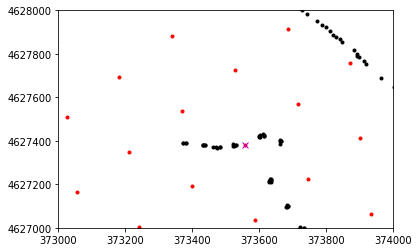

In [29]:
# plot to check that origin == correct coarse grid location
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xc,Yc,'.r');
plt.plot(xpm,ypm,'xm');
plt.xlim((3.73e5,3.74e5))
plt.ylim((4.627e6,4.628e6))

In [44]:
# medium grid box
dxf = dxyf
dyf = dxyf
LMf = 288
MMf = 126
# check to make sure it is divisible by dxc and dyc
print("These numbers should be integers:")
print((LMf-1)*dxf/dxm)
print((MMf-1)*dyf/dym)
# indices in coarse grid for origin of medium grid (found by hand)
row = 3
col = 95
# corresponding coordinates
xpf = Xm[row,col];
ypf = Ym[row,col];
print("Origin of fine grid")
print(xpf,ypf)
print('Fine grid is {} x {}, total = {}'.format(LMf,MMf,LMf*MMf))
Xf,Yf = buildGrid( 0., 0., alp-90., dxf, dyf, LMf, MMf );
Xf = Xf + xpf
Yf = Yf + ypf

These numbers should be integers:
41.0
17.857142857142858
Origin of fine grid
376171.530804 4625323.81169
Fine grid is 288 x 126, total = 36288
Shape of X and Y:  (126, 288) (126, 288)


(4624000.0, 4626000.0)

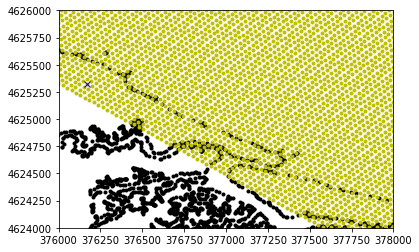

In [56]:
# plot to check that origin == correct coarse grid location
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xm,Ym,'.y');
plt.plot(xpf,ypf,'xb');
plt.xlim((3.760e5,3.78e5))
plt.ylim((4.624e6,4.626e6))

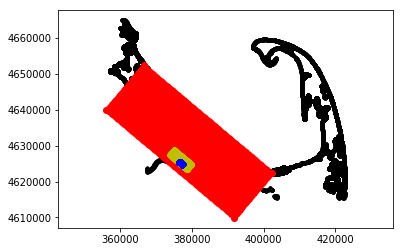

In [51]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(bc[:,0],bc[:,1],'or')
plt.plot(bc[:,0],bc[:,1],'-r')
plt.plot([bc[0,0], bc[3,0]],[bc[0,1], bc[3,1]],'-r')
plt.plot(Xc,Yc,'.r')
plt.plot(Xm,Ym,'.y')
plt.plot(Xf,Yf,'.b')
plt.axis('equal');

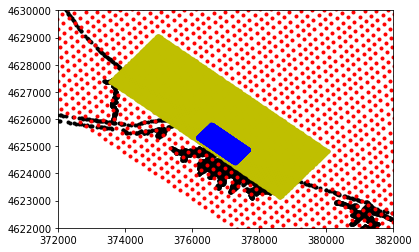

In [52]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xc,Yc,'.r')
plt.plot(Xm,Ym,'.y')
plt.plot(Xf,Yf,'.b')
plt.xlim((3.72e5,3.82e5))
plt.ylim((4.622e6,4.63e6));

(4624000.0, 4626000.0)

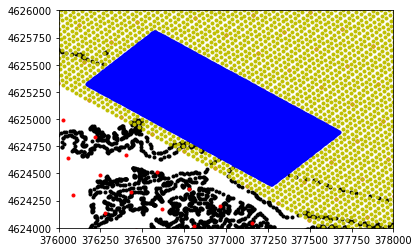

In [53]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xc,Yc,'.r')
plt.plot(Xm,Ym,'.y')
plt.plot(Xf,Yf,'.b')
plt.xlim((3.76e5,3.775e5))
plt.ylim((4.624e6,4.626e6))

In [33]:
print("Shape of point array: ",p.shape)
shp = X.shape
print("Shape of grid arrays X and Y:",shp)
print(np.shape(np.array((np.ravel(Xx), np.ravel(Y))).T))
print(np.shape(p[:,0:2]))
print(np.shape(p[:,2]))


NameError: name 'p' is not defined

In [ ]:
%%time
# interpolate data on to coarse grid
z= interpolate.griddata( p[:,0:2], p[:,2], np.array((np.ravel(X), np.ravel(Y))).T, method='linear', fill_value=np.NaN, rescale=False)

In [ ]:
%%time
# interpolate data on to coarse grid
zn= interpolate.griddata( p[:,0:2], p[:,2], np.array((np.ravel(X), np.ravel(Y))).T, method='nearest', fill_value=np.NaN, rescale=False)

In [ ]:
print(np.shape((X, Y)))
print(np.shape(X))

In [ ]:
shp = X.shape
print(np.ravel(X).shape)
print(np.squeeze(p[:,0:1]).shape)
print(np.squeeze(p[:,2]).shape)
print(np.min(p[:,0]),np.min(p[:,1]),np.min(p[:,2]))
print(np.max(p[:,0]),np.max(p[:,1]),np.max(p[:,2]))

print(z.shape)
z

In [ ]:
plt.scatter(np.ravel(X),np.ravel(Y),16,z)

In [ ]:
print(np.shape(points))
print(np.shape(values))